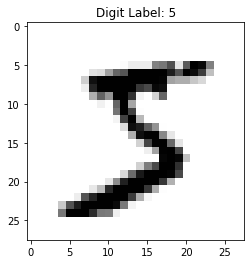

In [1]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
from main import *
md = MnistDataset()
X_train, y_train = md.train_dataset()
X_test, y_test = md.test_dataset()
    
df_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=range(X_train.shape[1]))
df_train_label = pd.DataFrame(y_train, index=range(y_train.shape[0]))

df_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=range(X_test.shape[1]))
df_test_label = pd.DataFrame(y_test, index=range(y_test.shape[0]))

#display(df_train_label)
first_image = df_train.iloc[0,:]
first_label = y_train[0]
#print(first_image)
#print(first_label)

# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image.values, (28, 28))
# Plot the image
plt.imshow(plottable_image, cmap='gray_r')
plt.title('Digit Label: {}'.format(first_label))

plt.show()

Let's try the voted perceptron algorithm

In [ ]:
# iris example
from main import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()

X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

error_random = []
error_last = []
error_avg = []
error_vote = []
kernel = 5

print("epoch: from 1 to 10 kernel:{}".format(kernel))
x1 = np.arange(1,500)
for i in tqdm(x1):
    array = []
    for j in range(3):
        array.append(model(X_train, y_train,j, i, kernel))
    models = np.array(array)
    e_r, e_l, e_a, e_v = test_error_iris(X_train,models, X_test, y_test, kernel)

    error_random.append(e_r*100)
    error_last.append(e_l*100)
    error_avg.append(e_a*100)
    error_vote.append(e_v*100)

log_plot(x1, error_random, error_last, error_avg, error_vote, kernel)